In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

### Loading and handling the data

In [ ]:
import pandas as pd 
import numpy as np 


In [ ]:
data = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv')
data.head()

In [ ]:
data.tail()

In [ ]:
data.dtypes

The data contains a particular month and the number of passengers during that month. In order to read the data as a time series, we have to pass special arguments to the read_csv command

In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)
print('Parsed data:')
data.head()

Arguments :

 - **parse_dates** : This specifies the column that contains the date-time information. The column name is 'Month'
 - **index_col** : A key idea of using pandas for TS data is that the index should specify the variable depicting the date-time data. So the argument tells pandas to use the 'Month' column as index.
 - **date_parser** : This specifies a function which converts an input string into datetime variable. Be default Pandas reads data in format ‘YYYY-MM-DD HH:MM:SS’. If the data is not in this format, the format has to be manually defined. Something similar to the dataparse function defined here can be used for this purpose.

In [ ]:
data.index

In [ ]:
ts = data['#Passengers']
ts.head(10)

In [ ]:
## Some indexting techniques for timeseries data 

# Selecting a particular value in the Series object

print(ts['1949-01-01'])

In [ ]:
# or 

from datetime import datetime 
print(ts[datetime(1949,1,1)])

In [ ]:
# Selecting a range of values

ts[:'1949-05-01']

Unlike numeric indexing, the end index is included here.

If we need all the values of the year 1949:

In [ ]:
ts['1949']

The month part of the datetime object is omitted. Similarly, if we want all days of a month, the day part can be omitted.

### Checking for Stationarity of the time series 
A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

There are three basic criteria for a time series to be stationary:

- The mean of the series should not be a function of time rather should be a constant. The image below has the left hand graph satisfying the condition whereas the graph in red has a time dependent mean.

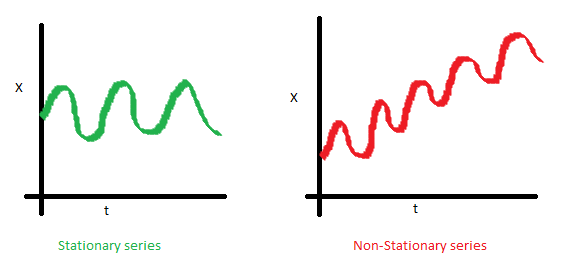

-  The variance of the series should not a be a function of time. This property is known as homoscedasticity. Following graph depicts what is and what is not a stationary series

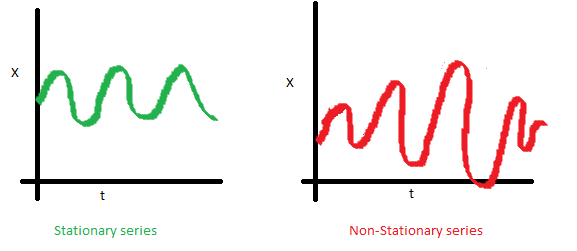

- The covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice the spread becomes closer as the time increases. Hence, the covariance is not constant with time for the ‘red series’.

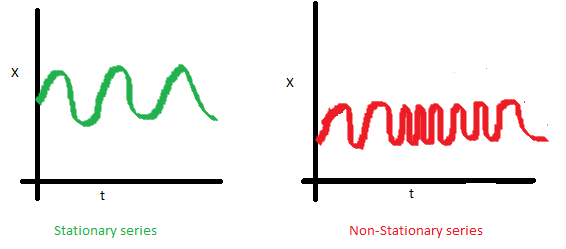

Let's start by simply plotting our time series 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ts)

It can be clearly seen that there is an increasing trend along with some seasonal variations. We can check stationarity using the following methods :

Plotting rolling statistics : We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. This is more of a visual technique

Dickey-Fuller test : This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

Let's create a simple function to plot the rolling statistics and to perform the Dickey-Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller 

def test_stationarity(timeseries):
    
    # determining rolling statistics 
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    # Plotting rolling statistics
    orig = plt.plot(timeseries, color='blue', label='original')
    mean = plt.plot(rolmean, color='red', label='Rolling mean')
    std = plt.plot(rolstd, color='black', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling mean and Standard deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller Test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags used', '#Ocservations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
        print(dfoutput)

In [ ]:
test_stationarity(ts)

Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values. Note that the signed values should be compared and not the absolute values

### How to make the Time Series stationary?
Its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:

 - Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
 - Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.
 
The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

Estimating and eliminating trend
 - One of the first tricks to eliminate trend is simple Transformation. Eg: Log transform which penalizes higher values more than smaller values.

In [ ]:
plt.plot(ts)

In [ ]:
ts_log = np.log(ts)
plt.plot(ts_log)

We can use some techniques to estimate or model the positive trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

 - Aggregation – taking average for a time period like monthly/weekly averages
 - Smoothing – taking rolling averages Polynomial Fitting – fit a regression model

**Smoothing** 
- Moving average 
In this approach, we take the average of 'k' consecutive values depending on the frequency of time series. Here, we can take the average over the past 1 year, i.e the last 12 months.

In [ ]:
moving_avg = pd.Series(ts_log).rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. This can be observed as:

In [ ]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

In [ ]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

This looks like a much better series and also the test statistic is smaller than 5% critical values. So we can say with 95% confidence that this is a stationary series.

Another method is to take a weighted moving average where more recent values are given more weight. There are many ways to assign weights. The most popular one is exponential weighted moving average.

In [ ]:
expweighted_avg = ts_log.ewm(span=12).mean()
plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

In [ ]:
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity(ts_log_ewma_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the previous case. Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

### Eliminating Trend and Seasonality
The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

- Difference - Taking the difference with a particular lag
- Decomposition - Modeling both trend and seasonality and then removing them from the model

**Differencing** :
One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity.

In [ ]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [ ]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence.

**Decomposing**:
In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Lets check stationarity of residuals:

In [ ]:
ts_log_decompose = residual 
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary.

### Forecasting a time series

ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

 - Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
 - Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
 - Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An important concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

 - Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
 - Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [ ]:
## ACF and PACF plots 

from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

In [ ]:
# plot ACF 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### ARIMA Model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

### AR model

In [ ]:
model = ARIMA(ts_log, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### MA model

In [ ]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### Combined model 

In [ ]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. Now, we are left with 1 last step, i.e. taking these values back to the original scale.

### Taking it back to original scale

Since the combined model gave best result, lets scale it back to the original values and see how well it performs there. First step would be to store the predicted results as a separate series and observe it.

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Notice that these start from ‘1949-02-01’ and not the first month. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:

In [ ]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Last step is to take the exponent and compare with the original series.

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))